<a href="https://www.kaggle.com/code/lonnieqin/titanic-prediction-with-different-models?scriptVersionId=114214696" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Titanic Prediction with Different Models
## Table of Contents
- Summary
- Import Packages
- Common Functions
- Import datasets
- Data Wrangling
- Data Preprocessing
    - Add Deck feature
    - Add family member size and faimily member type feature
    - Handle Categorical Features
- Exploratory Data Analysis
    - Basic Statistic infos
    - What's the factor to survive?
        - Gender
        - Age
        - Pclass
        - Fare
        - Cabin
        - Embarked
        - SibSp (Number of siblings or spouses)
        - Parch (Number of parents or children)
        - family member size
- More Data Preprocessing
    - Convert Categorical features to one hot features
    - Train Validation Split
    - Balance Training dataset
- Model Development and Evaluation
    - TensorFlow DNN
    - Deep and Wide Model
    - KNN
    - Decision Tree Classifier
    - Gradient Boosting Classifier
    - Random Forest Classifier
    - KMeans
    - XGBoost Classifier
    - Catboost Classifier
    - LGBM Classfier
- Submission
- Conclusions
    
## Summary
In this notebook I will do EDA and Data Preprocessing on Titanic Dataset, I will also implement Titannic Predicion using different kinds of classification Models.
- Deep Neural Network
- Deep and Wide Neural Network using keras DenseFeatures
- Logistic Regression
- KNN
- Decision Tree Classifier
- Gradient Boosting Classifier
- Random Forest Classifier
- KMeans
- XGBoost Classifier
- CatBoost Classfiier
- LGBM Classifier

## Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import tensorflow as tf
from tensorflow import feature_column
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import model_selection
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer

## Common Functions

In [2]:
def save_results(Survived, test, path):
    submission = pd.DataFrame({
        "PassengerId": test["PassengerId"],
        "Survived": Survived
    })
    submission.to_csv(path, index=False)

## Evaluate model

In [3]:
metrics = []

In [4]:
def evaluate(
    model, 
    name,
    validation_features, 
    validation_targets, 
    test_features, 
    columns = None
):
    if columns is None:
        feature_columns = validation_features.columns
    else:
        feature_columns = columns
    y_pred = model.predict(validation_features[feature_columns])
    if y_pred.dtype != int:
        if y_pred.shape[-1] == 2:
            y_pred = np.argmax(y_pred, axis=-1)
        if y_pred.shape[-1] == 1:
            y_pred = np.array(y_pred > 0.5, dtype=int)
    y_pred = y_pred.reshape(-1)
    accuracy = sklearn.metrics.accuracy_score(validation_targets, y_pred)
    f1 = sklearn.metrics.f1_score(validation_targets, y_pred)
    print("Accuracy Score:", accuracy)
    print("Classification Report:")
    print(sklearn.metrics.classification_report(validation_targets, y_pred))
    Survived = model.predict(test_features[feature_columns])
    
    if Survived.dtype != int:
        if Survived.shape[-1] == 2:
            Survived = np.argmax(Survived, axis=-1)
            proba = Survived[:, 1]
        elif Survived.shape[-1] == 1:
            proba = Survived.copy().reshape(-1)
            Survived = np.array(Survived > 0.5, dtype=int)
        else:
            proba = Survived.copy().reshape(-1)
    else:
        proba = Survived.copy().reshape(-1)
    Survived = np.array(Survived, dtype=int).reshape(-1)
    submit_path = f"{name}_submission.csv"
    submission = pd.DataFrame({
        "PassengerId": test["PassengerId"],
        "Survived": Survived,
        "proba": proba
    })
    submission.to_csv(submit_path, index=False)
    metric = {
        "model": model,
        "name": name,
        "submit_path": submit_path,
        "accuracy": accuracy,
        "f1": f1
    }
    metrics.append(metric)

## Import datasets

In [5]:
train = pd.read_csv("/kaggle/input/titanic/train.csv")
test = pd.read_csv("/kaggle/input/titanic/test.csv")

In [6]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## Data Wrangling

As we can see Age, Cabin and Fare information contains missing values, so we need to apply Missing Value  Imputation to them. The most common way is to replace categorical missing values with most fequent category and repalce numerical missing values with average value of that feature.

In [8]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [9]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [10]:
categorical_imputation_strategy = ["mode", "unknown", "knn"][1]
numerical_imputation_strategy = ["mean", "median", "knn"][2]

In [11]:
if categorical_imputation_strategy == "mode":
    train["Cabin"] = train["Cabin"].replace(np.NAN,  train["Cabin"].mode()[0])
    train["Embarked"] = train["Embarked"].replace(np.NAN, train["Embarked"].mode()[0])
if categorical_imputation_strategy == "unknown":
    train["Cabin"] = train["Cabin"].replace(np.NAN,  "Unknown")
    train["Embarked"] = train["Embarked"].replace(np.NAN, "Unknown")
    test["Cabin"] = test["Cabin"].replace(np.NAN, "Unknown")
if categorical_imputation_strategy == "knn":
    print("To be continued")
if numerical_imputation_strategy == "mean":
    train["Age"] = train["Age"].replace(np.NAN, train["Age"].mean())
    test["Age"] = test["Age"].replace(np.NAN, test["Age"].mean())
    test["Fare"] = test["Fare"].replace(np.NAN, test["Fare"].mean())
if numerical_imputation_strategy == "median":
    train["Age"] = train["Age"].replace(np.NAN, train["Age"].median())
    test["Age"] = test["Age"].replace(np.NAN, test["Age"].median())
    test["Fare"] = test["Fare"].replace(np.NAN, test["Fare"].median())
if numerical_imputation_strategy == "knn":
    imputer = KNNImputer(n_neighbors=5)
    columns = ["Age", "Fare", "SibSp", "Parch"]
    train[columns] = imputer.fit_transform(train[columns])
    test[columns] = imputer.transform(test[columns])

## Data Preprocessing

### Add Deck feature

First letter of cabin stands for deck, it indicated the location and class of the Passengers so it had an impact to survive.

In [12]:
cabin_labels = sorted(set(list(train["Cabin"].unique()) + list(test["Cabin"].unique())))
print(cabin_labels[:30])

['A10', 'A11', 'A14', 'A16', 'A18', 'A19', 'A20', 'A21', 'A23', 'A24', 'A26', 'A29', 'A31', 'A32', 'A34', 'A36', 'A5', 'A6', 'A7', 'A9', 'B10', 'B101', 'B102', 'B11', 'B18', 'B19', 'B20', 'B22', 'B24', 'B26']


In [13]:
train["Deck"] = train["Cabin"].apply(lambda cabin: cabin[0])
test["Deck"] = test["Cabin"].apply(lambda cabin: cabin[0])

### Add family member size and faimily member type Column

We can indicate family member size by SibSp and Parch feature: 

In [14]:
train["family_member_size"] = 1 + train["SibSp"] + train["Parch"]
test["family_member_size"] = 1 + test["SibSp"] + test["Parch"]

According to the EDA below, Family member size had a impact on Survival, but it was not a linear relationship, that was why it had a low pearson correlation score. So I will convert it to a categorical feature with single(1 family member), medium(2-4 family members), large(more than 4 members). I will add a Feature Toggle here to control whether to use this function

In [15]:
def convert_faimly_member_size(size):
    if size == 1:
        return "single"
    elif size < 5:
        return "medium"
    else:
        return "large"
should_add_family_member_type = False
if should_add_family_member_type:
    for data in [train, test]:
        data["family_member_type"] = train["family_member_size"].apply(convert_faimly_member_size)

### Handle Categorical Features

In [16]:
categorical_features = ["Sex", "Deck", "Embarked"]
if should_add_family_member_type:
    categorical_features.append("family_member_type")
categorical_label_dictionary = dict()
for feature in categorical_features:
    unique_labels = sorted(set(list(train[feature].unique()) + list(test[feature].unique())))
    for data in [train, test]:
        categorical_label_dictionary[feature] = unique_labels
        data[feature + "_value"] = data[feature].apply(lambda item: unique_labels.index(item))

Let's see after we preprocess, what does the data look like?

In [17]:
train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck,family_member_size,Sex_value,Deck_value,Embarked_value
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1.0,0.0,A/5 21171,7.2500,Unknown,S,U,2.0,1,8,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1.0,0.0,PC 17599,71.2833,C85,C,C,2.0,0,2,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0.0,0.0,STON/O2. 3101282,7.9250,Unknown,S,U,1.0,0,8,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1.0,0.0,113803,53.1000,C123,S,C,2.0,0,2,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0.0,0.0,373450,8.0500,Unknown,S,U,1.0,1,8,2
5,6,0,3,"Moran, Mr. James",male,24.8,0.0,0.0,330877,8.4583,Unknown,Q,U,1.0,1,8,1
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0.0,0.0,17463,51.8625,E46,S,E,1.0,1,4,2
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3.0,1.0,349909,21.0750,Unknown,S,U,5.0,1,8,2
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0.0,2.0,347742,11.1333,Unknown,S,U,3.0,0,8,2
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1.0,0.0,237736,30.0708,Unknown,C,U,2.0,0,8,0


## Exploratory Data Analysis

### Basic Statistic infos

In [18]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   PassengerId         891 non-null    int64  
 1   Survived            891 non-null    int64  
 2   Pclass              891 non-null    int64  
 3   Name                891 non-null    object 
 4   Sex                 891 non-null    object 
 5   Age                 891 non-null    float64
 6   SibSp               891 non-null    float64
 7   Parch               891 non-null    float64
 8   Ticket              891 non-null    object 
 9   Fare                891 non-null    float64
 10  Cabin               891 non-null    object 
 11  Embarked            891 non-null    object 
 12  Deck                891 non-null    object 
 13  family_member_size  891 non-null    float64
 14  Sex_value           891 non-null    int64  
 15  Deck_value          891 non-null    int64  
 16  Embarked

In [19]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,family_member_size,Sex_value,Deck_value,Embarked_value
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,30.094880,0.523008,0.381594,32.204208,1.904602,0.647587,6.716049,1.538721
std,257.353842,0.486592,0.836071,13.497779,1.102743,0.806057,49.693429,1.613459,0.477990,2.460739,0.794231
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400,1.000000,0.000000,8.000000,1.000000
50%,446.000000,0.000000,3.000000,28.500000,0.000000,0.000000,14.454200,1.000000,1.000000,8.000000,2.000000
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000,2.000000,1.000000,8.000000,2.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,11.000000,1.000000,8.000000,3.000000


### What's the factor to survive?
As we can see it's related to Gender, PClass, Status, Fare, Deck and Embarked. 

In [20]:
train.corr()["Survived"].sort_values(key=lambda x: abs(x), ascending=False)

Survived              1.000000
Sex_value            -0.543351
Pclass               -0.338481
Deck_value           -0.301116
Fare                  0.257307
Embarked_value       -0.163517
Parch                 0.081629
Age                  -0.058335
SibSp                -0.035322
family_member_size    0.016639
PassengerId          -0.005007
Name: Survived, dtype: float64

In [21]:
related_columns = list(train.corr()[train.corr()["Survived"].abs() > 0.05].index)
related_columns.remove("Survived")
print(related_columns)

['Pclass', 'Age', 'Parch', 'Fare', 'Sex_value', 'Deck_value', 'Embarked_value']


#### Gender
Women have a higher Survival rate than Men.

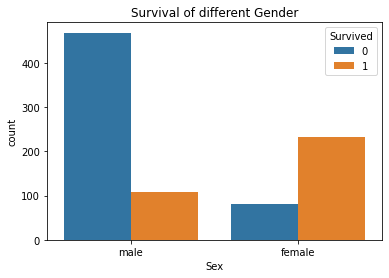

In [22]:
sns.countplot(x="Sex", hue="Survived", data=train)
plt.title("Survival of different Gender")
plt.show()

#### Age


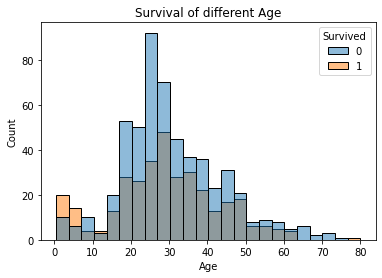

In [23]:
sns.histplot(x="Age", hue="Survived", data=train)
plt.title("Survival of different Age")
plt.show()

#### Pclass
- Passengers from Pclass 1 had 62% Survival Rate;
- Passengers from Pclass 2 had 47% Survival Rate;
- Passengers from Pclass 3 had 24% Survival Rate;

In [24]:
train.groupby("Pclass")["Survived"].mean()

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

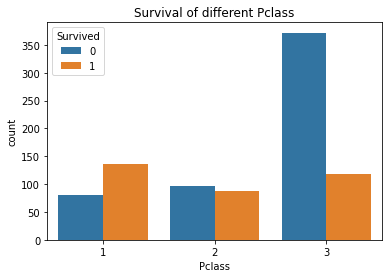

In [25]:
sns.countplot(x="Pclass", hue="Survived", data=train)
plt.title("Survival of different Pclass")
plt.show()

#### Fare
Most of the tickets were less than 100 pounds. Only about 1 / 5 with fare around 10 pounds survived.

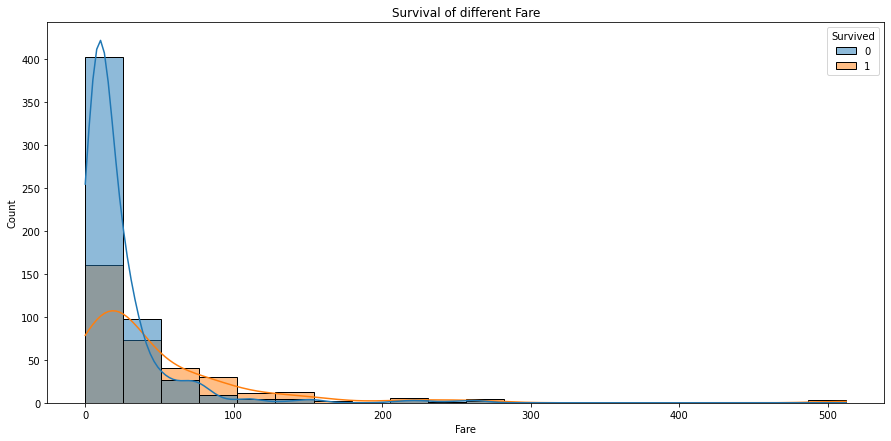

In [26]:
plt.figure(figsize=(15, 7))
sns.histplot(x="Fare", hue="Survived", bins=20, kde=True, data=train)
plt.title("Survival of different Fare")
plt.show()

#### Deck
- More than half Passengers from Deck C, D, E, F, G survived;
- Less than half Passengers from Deck A,B survived;
- 30% of Passengers with unknown Deck survived;
- Almost no Passengers from Deck T survived.

In [27]:
train.groupby("Deck")["Survived"].mean()

Deck
A    0.466667
B    0.744681
C    0.593220
D    0.757576
E    0.750000
F    0.615385
G    0.500000
T    0.000000
U    0.299854
Name: Survived, dtype: float64

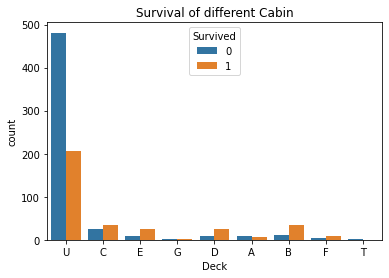

In [28]:
sns.countplot(x="Deck", hue="Survived", data=train)
plt.title("Survival of different Cabin")
plt.show()

#### Embarked
- About 1 / 3 passengers from Embarked Q, S survived;
- About half passengers from Embarked C survived;

In [29]:
train.groupby("Embarked")["Survived"].mean()

Embarked
C          0.553571
Q          0.389610
S          0.336957
Unknown    1.000000
Name: Survived, dtype: float64

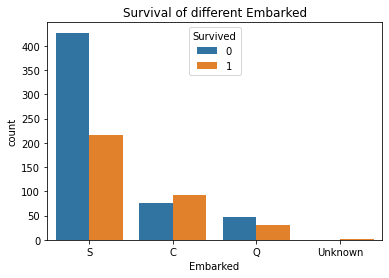

In [30]:
sns.countplot(x="Embarked", hue="Survived", data=train)
plt.title("Survival of different Embarked")
plt.show()

#### SibSp (Number of siblings or spouse)
- Passengers without siblings or spouse had 1 / 3 Survival Rate.
- Passengers with one or two siblings or spouse had about 1 / 2 Survival Rate.
- Passengers with more than two siblings or spouse were less likely to survive.

In [31]:
train.groupby("SibSp")["Survived"].mean()

SibSp
0.0    0.345395
1.0    0.535885
2.0    0.464286
3.0    0.250000
4.0    0.166667
5.0    0.000000
8.0    0.000000
Name: Survived, dtype: float64

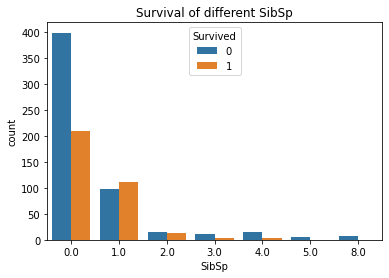

In [32]:
sns.countplot(x="SibSp", hue="Survived", data=train)
plt.title("Survival of different SibSp")
plt.show()

#### Parch (Number of parents or children)
- Passengers without parents or children had 1 / 3 survival rate.
- Passengers with 1 - 3 parents or children had 1 / 2 survival rate.
- Passengers with more than 4 parents or children were less likely to survive.


In [33]:
train.groupby("Parch")["Survived"].mean()

Parch
0.0    0.343658
1.0    0.550847
2.0    0.500000
3.0    0.600000
4.0    0.000000
5.0    0.200000
6.0    0.000000
Name: Survived, dtype: float64

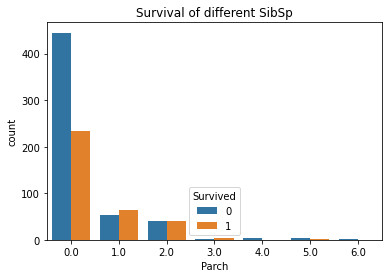

In [34]:
sns.countplot(x="Parch", hue="Survived", data=train)
plt.title("Survival of different SibSp")
plt.show()

#### Family member size
- Those who were alone (1 family member size) had 1 / 3 Survival Rate.
- Those who had 2 - 4 family member size had more than 1 / 2 Survival Rate.
- Those who had 5 - 11 family member size were less likely to survive.

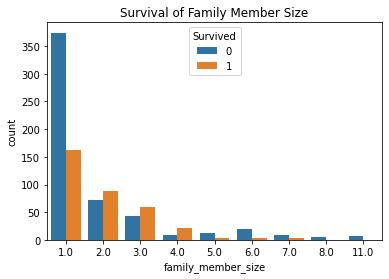

In [35]:
sns.countplot(x="family_member_size", hue="Survived", data=train)
plt.title("Survival of Family Member Size")
plt.show()

After converting family member size to categorical feature, the relation between family member size and survival rate were more obvious.

In [36]:
if should_add_family_member_type:
    sns.countplot(x="family_member_type", hue="Survived", data=train)
    plt.title("Survival of Family Member Type")
    plt.show()

## More data Preprocessing

In [37]:
train_test = pd.concat([train, test])
train_test.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck,family_member_size,Sex_value,Deck_value,Embarked_value
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1.0,0.0,A/5 21171,7.2500,Unknown,S,U,2.0,1,8,2
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1.0,0.0,PC 17599,71.2833,C85,C,C,2.0,0,2,0
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0.0,0.0,STON/O2. 3101282,7.9250,Unknown,S,U,1.0,0,8,2
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1.0,0.0,113803,53.1000,C123,S,C,2.0,0,2,2
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0.0,0.0,373450,8.0500,Unknown,S,U,1.0,1,8,2


### Convert Categorical features to one hot features

In [38]:
categorical_columns_to_one_hot = ["Sex", "Deck", "Embarked"]
if should_add_family_member_type:
    categorical_columns_to_one_hot.append("family_member_type")
for feature in categorical_columns_to_one_hot:
    items = pd.get_dummies(train_test[feature + "_value"])
    labels = categorical_label_dictionary[feature]
    items.columns = [feature + "_" + labels[column] for column in list(items.columns)]
    train_test[items.columns] = items
    train_test.pop(feature + "_value")

Calucate mean and std value for future use.

In [39]:
mean_value = train_test.mean()
std_value = train_test.std()
mean_value.pop("Survived")
_ = std_value.pop("Survived")

In [40]:
train_test.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_U,Embarked_C,Embarked_Q,Embarked_S,Embarked_Unknown
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1.0,0.0,A/5 21171,7.2500,...,0,0,0,0,0,1,0,0,1,0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1.0,0.0,PC 17599,71.2833,...,0,0,0,0,0,0,1,0,0,0
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0.0,0.0,STON/O2. 3101282,7.9250,...,0,0,0,0,0,1,0,0,1,0
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1.0,0.0,113803,53.1000,...,0,0,0,0,0,0,0,0,1,0
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0.0,0.0,373450,8.0500,...,0,0,0,0,0,1,0,0,1,0


### Remove unused columns

In [41]:
for column in ["Name", "Sex", "Ticket", "Cabin", "Deck", "Embarked", "family_member_size", "family_member_type"]:
    if column in train_test.columns:
        train_test.pop(column)

In [42]:
train_features = train_test.iloc[0: len(train)]
test_features = train_test.iloc[len(train):]

In [43]:
train_features.pop("PassengerId")
test_features.pop("Survived")
train_features.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Deck_A,Deck_B,...,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_U,Embarked_C,Embarked_Q,Embarked_S,Embarked_Unknown
0,0.0,3,22.0,1.0,0.0,7.2500,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0
1,1.0,1,38.0,1.0,0.0,71.2833,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,1.0,3,26.0,0.0,0.0,7.9250,1,0,0,0,...,0,0,0,0,0,1,0,0,1,0
3,1.0,1,35.0,1.0,0.0,53.1000,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0.0,3,35.0,0.0,0.0,8.0500,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0


In [44]:
test_features.head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Deck_A,Deck_B,...,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_U,Embarked_C,Embarked_Q,Embarked_S,Embarked_Unknown
0,892,3,34.5,0.0,0.0,7.8292,0,1,0,0,...,0,0,0,0,0,1,0,1,0,0
1,893,3,47.0,1.0,0.0,7.0000,1,0,0,0,...,0,0,0,0,0,1,0,0,1,0
2,894,2,62.0,0.0,0.0,9.6875,0,1,0,0,...,0,0,0,0,0,1,0,1,0,0
3,895,3,27.0,0.0,0.0,8.6625,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0
4,896,3,22.0,1.0,1.0,12.2875,1,0,0,0,...,0,0,0,0,0,1,0,0,1,0


### Train Validation Split

In [45]:
validation_split = 0.2

In [46]:
train_features, validation_features = model_selection.train_test_split(train_features, test_size=validation_split, stratify=train_features["Survived"], random_state=42)
print(train_features.shape, validation_features.shape)

(712, 21) (179, 21)


In [47]:
train_features.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Deck_A,Deck_B,...,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_U,Embarked_C,Embarked_Q,Embarked_S,Embarked_Unknown
692,1.0,3,29.6,0.0,0.0,56.4958,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0
481,0.0,2,36.4,0.0,0.0,0.0000,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0
527,0.0,1,30.8,0.0,0.0,221.7792,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
855,1.0,3,18.0,0.0,1.0,9.3500,1,0,0,0,...,0,0,0,0,0,1,0,0,1,0
801,1.0,2,31.0,1.0,1.0,26.2500,1,0,0,0,...,0,0,0,0,0,1,0,0,1,0


### Balance Training dataset
Let's balance the training dataset and add some noise to data. I will add a Toggle here to control whether to balance the dataset.

In [48]:
should_balance = False
batch_size = 32
number_batch_per_category = 100
if should_balance == True:
    survived = train_features[train_features.Survived == 1]
    not_survived = train_features[train_features.Survived == 0]
    survived_indices = list(np.random.choice(len(survived), size=number_batch_per_category * batch_size))
    not_survived_indices = list(np.random.choice(len(not_survived), size=number_batch_per_category * batch_size))
    survived_features = survived.iloc[survived_indices]
    not_survived_features = not_survived.iloc[not_survived_indices]
    print(not_survived_features.shape)
    train_features = pd.concat([survived_features, not_survived_features])
    train_features = sklearn.utils.shuffle(train_features)
    train_targets = train_features.pop("Survived")
    validation_targets = validation_features.pop("Survived")
    # 0.95 ~ 1.05
    scale = 1 + 0.1 * (np.random.rand(train_features.shape[0], train_features.shape[1]) - 0.5)
    train_features =  train_features * scale
else:
    train_targets = train_features.pop("Survived")
    validation_targets = validation_features.pop("Survived")

After balancing the training dataset

In [49]:
train_features.describe()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_U,Embarked_C,Embarked_Q,Embarked_S,Embarked_Unknown
count,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000
mean,2.308989,30.100567,0.492978,0.390449,31.819826,0.355337,0.644663,0.019663,0.047753,0.057584,0.036517,0.040730,0.015449,0.005618,0.001404,0.775281,0.195225,0.077247,0.724719,0.002809
std,0.833563,13.445101,1.060720,0.838134,48.059104,0.478952,0.478952,0.138937,0.213393,0.233119,0.187704,0.197804,0.123419,0.074795,0.037477,0.417691,0.396652,0.267171,0.446970,0.052963
min,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,22.000000,0.000000,0.000000,7.895800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,29.000000,0.000000,0.000000,14.454200,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,3.000000,38.000000,1.000000,0.000000,31.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
max,3.000000,80.000000,8.000000,6.000000,512.329200,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Feature Scaling

In [50]:
train_features.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_U,Embarked_C,Embarked_Q,Embarked_S,Embarked_Unknown
692,3,29.6,0.0,0.0,56.4958,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0
481,2,36.4,0.0,0.0,0.0000,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0
527,1,30.8,0.0,0.0,221.7792,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0
855,3,18.0,0.0,1.0,9.3500,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0
801,2,31.0,1.0,1.0,26.2500,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0


In [51]:
data_scaling_strategies = ["none", "max", "standard"]
data_scaling_strategy = data_scaling_strategies[2]
if data_scaling_strategy == data_scaling_strategies[1]:
    features_max = pd.concat([train_features, validation_features]).max()
    train_features = train_features / features_max
    validation_features = validation_features / features_max
    test_features[train_features.columns] = test_features[train_features.columns] / features_max
if data_scaling_strategy == data_scaling_strategies[2]:
    for data in [train_features, validation_features, test_features]:
        columns_to_scale = ["Age", "Fare"]
        data.loc[:, columns_to_scale] = (data.loc[:, columns_to_scale]  - mean_value[columns_to_scale]) / std_value[columns_to_scale]
print(train_features.shape)
print(test_features.shape)

(712, 20)
(418, 21)


/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)


## Model Development & Evaluation
I will try different Models and use results from best Model.

### TensorFlow DNN

<AxesSubplot:>

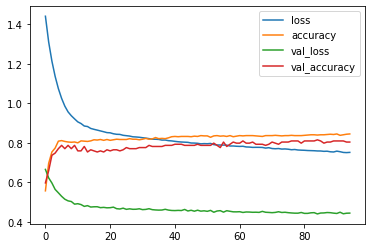

In [52]:
class_weight = dict(len(train_targets) / train_targets.value_counts())
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(train_features.shape[1])),
    tf.keras.layers.Dense(32, activation='relu'),
    #tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
early_stop = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(
    train_features, train_targets, 
    epochs=400, 
    class_weight=class_weight,
    validation_data=(validation_features, validation_targets), 
    callbacks=[early_stop],
    verbose=0
)
pd.DataFrame(history.history).plot()

In [53]:
evaluate(
    model, 
    "dnn",
    validation_features, 
    validation_targets, 
    test_features,
    columns=validation_features.columns
)

Accuracy Score: 0.8156424581005587
Classification Report:
              precision    recall  f1-score   support

         0.0       0.85      0.85      0.85       110
         1.0       0.76      0.77      0.76        69

    accuracy                           0.82       179
   macro avg       0.81      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179



### Deep and Wide Model

In [54]:
categorical_feature_names = ["Pclass", "Embarked_value", "Deck_value"]
if should_add_family_member_type:
    categorical_feature_names.append("family_member_type_value")
numerical_feature_names = ["Age", "Sex_value", "Fare", "SibSp", "Parch"]
categorical_features = [
    feature_column.indicator_column(
        feature_column.categorical_column_with_vocabulary_list(key, sorted(list(train[key].unique())))
    ) for key in categorical_feature_names
]
numerical_features = [feature_column.numeric_column(key) for key in numerical_feature_names]
inputs = dict()
for item in numerical_features:
    inputs[item.key] = tf.keras.layers.Input(name=item.key, shape=())
for item in categorical_features:
    inputs[item.categorical_column.key] = tf.keras.layers.Input(name=item.categorical_column.key, shape=(), dtype="int32")

In [55]:
def features_and_labels(features):
    label = features.pop("Survived")
    return features, label

def create_dataset(pattern, epochs=1, batch_size=32, mode='eval'):
    dataset = tf.data.experimental.make_csv_dataset(
        pattern, 
        batch_size
    )
    dataset = dataset.map(features_and_labels)
    if mode == 'train':
        dataset = dataset.shuffle(buffer_size=128)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

def create_test_dataset(pattern, batch_size=32):
    dataset = tf.data.experimental.make_csv_dataset(
        pattern, batch_size
    )
    dataset = dataset.map(lambda features: features)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [56]:
train_data, val_data = train_test_split(
    train[categorical_feature_names + numerical_feature_names + ["Survived"]],
    test_size=validation_split,
    stratify=train["Survived"],
    random_state=42
)
train_data.to_csv("train_data.csv", index=False)
val_data.to_csv("val_data.csv", index=False)
test[categorical_feature_names + numerical_feature_names].to_csv("test_data.csv", index=False)
train_dataset = create_dataset("train_data.csv", batch_size=batch_size, mode='train')
val_dataset = create_dataset("val_data.csv", batch_size=val_data.shape[0], mode='eval').take(1)
test_dataset = create_test_dataset("test_data.csv", batch_size = test.shape[0]).take(1)

In [57]:
def build_deep_and_wide_model():
    deep = tf.keras.layers.DenseFeatures(numerical_features, name='deep')(inputs)
    wide = tf.keras.layers.DenseFeatures(categorical_features, name='wide')(inputs)
    deep = tf.keras.layers.Dense(32, activation='relu')(deep)
    deep = tf.keras.layers.Dropout(0.1)(deep)
    deep = tf.keras.layers.Dense(32, activation='relu')(deep)
    deep = tf.keras.layers.Dropout(0.1)(deep)
    deep = tf.keras.layers.Dense(32, activation='relu')(deep)
    deep = tf.keras.layers.Dropout(0.1)(deep)
    deep = tf.keras.layers.Dense(32, activation='relu')(deep)
    deep = tf.keras.layers.Dropout(0.1)(deep)
    deep = tf.keras.layers.Dense(32, activation='relu')(deep)
    deep = tf.keras.layers.Dropout(0.1)(deep)
    vector = tf.keras.layers.Concatenate()([deep, wide])
    vector = tf.keras.layers.Dense(32, activation='relu')(vector)
    vector = tf.keras.layers.Dropout(0.1)(vector)
    vector = tf.keras.layers.Dense(32, activation='relu')(vector)
    vector = tf.keras.layers.Dropout(0.1)(vector)
    output = tf.keras.layers.Dense(1, activation="sigmoid")(vector)
    model = tf.keras.Model(inputs=list(inputs.values()), outputs=output)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

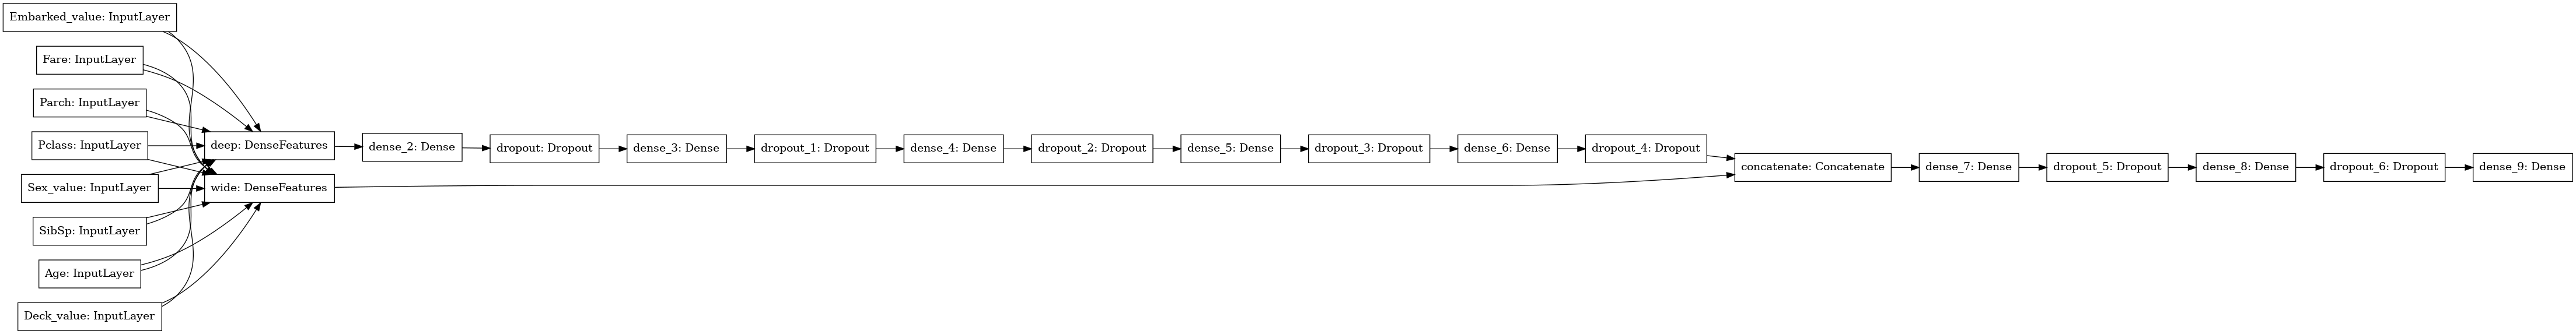

In [58]:
deep_and_wide_model = build_deep_and_wide_model()
tf.keras.utils.plot_model(deep_and_wide_model, show_shapes=False, rankdir='LR')

<AxesSubplot:>

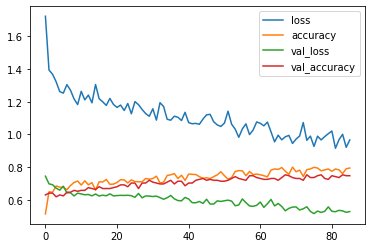

In [59]:
epochs = 400
early_stop = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
steps_per_epoch = train_data.shape[0] // batch_size
class_weight = dict(len(train_targets) / train_targets.value_counts())
history = deep_and_wide_model.fit(
    train_dataset, 
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[early_stop],
    class_weight=class_weight,
    verbose=0
)
pd.DataFrame(history.history).plot()

In [60]:
y_pred =  np.array(deep_and_wide_model.predict(val_dataset) > 0.5, dtype=int).reshape(-1)
score = accuracy_score(val_data["Survived"], y_pred)
print("Accuracy score:", score)
print(sklearn.metrics.classification_report(val_data["Survived"], y_pred))
Survived = np.argmax(deep_and_wide_model.predict(test_dataset), axis=-1).reshape(-1)
print(Survived.shape)
path = "submission_dnn_dense_features_model.csv"
save_results(Survived, test, path)

Accuracy score: 0.6033519553072626
              precision    recall  f1-score   support

           0       0.69      0.65      0.67       110
           1       0.49      0.52      0.50        69

    accuracy                           0.60       179
   macro avg       0.59      0.59      0.59       179
weighted avg       0.61      0.60      0.61       179

(418,)


### Logistic Regression

In [61]:
logitistc_related_columns = list(train.corr()[train.corr()["Survived"].abs() > 0.05].index)
logitistc_related_columns.remove("Survived")
logitistc_related_columns

['Pclass', 'Age', 'Parch', 'Fare', 'Sex_value', 'Deck_value', 'Embarked_value']

In [62]:
from sklearn.linear_model import LogisticRegression
best_logit = None
best_solver = ""
best_logit_score = 0
logit_train_features, logit_val_features = train_test_split(train[logitistc_related_columns +  ["Survived"]], test_size=0.2, random_state=48)
logit_train_targets = logit_train_features.pop("Survived")
logit_val_targets = logit_val_features.pop("Survived")
for solver in ['newton-cg', 'lbfgs', 'liblinear']:
    logit = LogisticRegression(solver=solver)
    logit.fit(logit_train_features, logit_train_targets)
    score = logit.score(logit_val_features, logit_val_targets)
    if score > best_logit_score:
        best_solver = solver
        best_logit_score = score
        best_logit = logit
print("Best Solver:", best_solver, "Score:", best_logit_score)

Best Solver: liblinear Score: 0.8044692737430168


In [63]:
evaluate(
    best_logit, 
    "logistic",
    logit_val_features, 
    logit_val_targets, 
    test,
    columns=logitistc_related_columns
)

Accuracy Score: 0.8044692737430168
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.84      0.84       108
           1       0.76      0.75      0.75        71

    accuracy                           0.80       179
   macro avg       0.80      0.79      0.80       179
weighted avg       0.80      0.80      0.80       179



### KNN

In [64]:
best_algorithm = ""
best_knn_score = 0
best_knn = None
best_n = 2
for n in range(2, 10):
    knn = KNeighborsClassifier(n, algorithm='ball_tree')
    knn.fit(train_features, train_targets)
    score = knn.score(validation_features, validation_targets) 
    if score > best_knn_score:
        best_n = n
        best_knn_score = score
        best_knn = knn
print("Best KNN Score: ", best_knn_score, "Model:", best_knn, "Best N:", best_n)

Best KNN Score:  0.8044692737430168 Model: KNeighborsClassifier(algorithm='ball_tree', n_neighbors=7) Best N: 7


In [65]:
evaluate(
    best_knn, 
    "knn",
    validation_features, 
    validation_targets, 
    test_features
)

Accuracy Score: 0.8044692737430168
Classification Report:
              precision    recall  f1-score   support

         0.0       0.82      0.87      0.85       110
         1.0       0.77      0.70      0.73        69

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179



### Decision Tree Classifier

In [66]:
from sklearn.tree import DecisionTreeClassifier
best_tree = None
best_tree_score = 0
for max_depth in range(6, 30):
    tree = sklearn.tree.DecisionTreeClassifier(max_depth=max_depth)
    tree.fit(train_features, train_targets)
    score = tree.score(validation_features, validation_targets)
    if score > best_tree_score:
        best_tree_score = score
        best_tree = tree
print("Best Decision Tree Score: ", best_tree_score, "Model:", best_tree)

Best Decision Tree Score:  0.7932960893854749 Model: DecisionTreeClassifier(max_depth=8)


In [67]:
evaluate(
    best_tree, 
    "decision_tree",
    validation_features, 
    validation_targets, 
    test_features
)

Accuracy Score: 0.7932960893854749
Classification Report:
              precision    recall  f1-score   support

         0.0       0.78      0.92      0.85       110
         1.0       0.82      0.59      0.69        69

    accuracy                           0.79       179
   macro avg       0.80      0.76      0.77       179
weighted avg       0.80      0.79      0.79       179



### Gradient Boosting Classifier

In [68]:
best_gbc_score = 0
best_depth = 5
best_n_estimators = 5
best_learning_rate = 0.1
best_gbc_model = None
for learning_rate in list(np.arange(0.05, 0.15, 0.01)):
    gbc = GradientBoostingClassifier(
            n_estimators=best_n_estimators, 
            learning_rate=learning_rate, 
            max_depth=best_depth, 
            random_state=np.random.randint(1, 1000)
    )
    gbc.fit(train_features, train_targets)
    score = gbc.score(validation_features, validation_targets)
    if score > best_gbc_score:
        best_learning_rate = learning_rate
        best_gbc_score = score
        best_gbc_model = gbc
print("Best Learning Rate:", best_learning_rate)
for depth in range(5, 20):
    gbc = GradientBoostingClassifier(
            n_estimators=best_n_estimators, 
            learning_rate=best_learning_rate, 
            max_depth=depth, 
            random_state=np.random.randint(1, 1000)
    )
    gbc.fit(train_features, train_targets)
    score = gbc.score(validation_features, validation_targets)
    if score > best_gbc_score:
        best_depth = depth
        best_gbc_score = score
        best_gbc_model = gbc
print("Best Depth:", best_depth)
for n_estimators in range(5, 15):
    gbc = GradientBoostingClassifier(
            n_estimators=n_estimators, 
            learning_rate=best_learning_rate, 
            max_depth=best_depth, 
            random_state=np.random.randint(1, 1000)
    )
    gbc.fit(train_features, train_targets)
    score = gbc.score(validation_features, validation_targets)
    if score > best_gbc_score:
        best_n_estimators = n_estimators
        best_gbc_score = score
        best_gbc_model = gbc
print("Best Number of Estimator:", best_depth)
print("Best Gradient Boosting Classifier Score:", best_gbc_score, " Model:", best_gbc_model)

Best Learning Rate: 0.07
Best Depth: 10
Best Number of Estimator: 10
Best Gradient Boosting Classifier Score: 0.8212290502793296  Model: GradientBoostingClassifier(learning_rate=0.07, max_depth=10, n_estimators=10,
                           random_state=776)


In [69]:
evaluate(
    best_gbc_model, 
    "gradient_boosting_tree",
    validation_features, 
    validation_targets, 
    test_features
)

Accuracy Score: 0.8212290502793296
Classification Report:
              precision    recall  f1-score   support

         0.0       0.81      0.92      0.86       110
         1.0       0.84      0.67      0.74        69

    accuracy                           0.82       179
   macro avg       0.83      0.79      0.80       179
weighted avg       0.82      0.82      0.82       179



### Random Forest Classifier

In [70]:
best_forest = None
best_max_depth = 8
best_n_estimators = 15
best_forest_score = 0
print("Find best number of estimators")
for n_estimators in list(range(3, 40, 2)):
    forest = RandomForestClassifier(
        n_estimators=n_estimators, 
        max_depth=best_max_depth, 
        random_state=np.random.randint(1, 1000)
    )
    forest.fit(train_features, train_targets)
    score = forest.score(validation_features, validation_targets)
    print("Score: ", score)
    if score > best_forest_score:
        best_n_estimators = n_estimators
        best_forest_score = score
        best_forest = forest
print("Best Number of Estimator:", best_n_estimators)
for max_depth in range(4, 15):
    forest = RandomForestClassifier(
        n_estimators=best_n_estimators, 
        max_depth=max_depth, 
        random_state=np.random.randint(1, 1000)
    )
    forest.fit(train_features, train_targets)
    score = forest.score(validation_features, validation_targets)
    print("Score: ", score)
    if score > best_forest_score:
        best_max_depth = max_depth
        best_forest_score = score
        best_forest = forest
print("Best Max Depth:", best_max_depth,"\nBest score:", best_forest_score)

Find best number of estimators
Score:  0.776536312849162
Score:  0.7877094972067039
Score:  0.8268156424581006
Score:  0.8044692737430168
Score:  0.7932960893854749
Score:  0.8044692737430168
Score:  0.7877094972067039
Score:  0.7877094972067039
Score:  0.8100558659217877
Score:  0.7821229050279329
Score:  0.7988826815642458
Score:  0.776536312849162
Score:  0.8100558659217877
Score:  0.7821229050279329
Score:  0.7821229050279329
Score:  0.8044692737430168
Score:  0.8156424581005587
Score:  0.7932960893854749
Score:  0.7988826815642458
Best Number of Estimator: 7
Score:  0.7988826815642458
Score:  0.7988826815642458
Score:  0.8044692737430168
Score:  0.7932960893854749
Score:  0.8044692737430168
Score:  0.7877094972067039
Score:  0.776536312849162
Score:  0.7988826815642458
Score:  0.770949720670391
Score:  0.7877094972067039
Score:  0.770949720670391
Best Max Depth: 8 
Best score: 0.8268156424581006


In [71]:
evaluate(
    best_forest, 
    "random_forest",
    validation_features, 
    validation_targets, 
    test_features
)

Accuracy Score: 0.8268156424581006
Classification Report:
              precision    recall  f1-score   support

         0.0       0.82      0.92      0.87       110
         1.0       0.84      0.68      0.75        69

    accuracy                           0.83       179
   macro avg       0.83      0.80      0.81       179
weighted avg       0.83      0.83      0.82       179



## KMeans
Kmeans separate people into two groups. One group who were likely survie and another group who were not likely survie.

In [72]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(train_features, train_targets)

KMeans(n_clusters=2)

In [73]:
y_pred = kmeans.predict(train_features)
print(y_pred.mean())
if y_pred.mean() < 0.5:
    evaluate(
        kmeans, 
        "kmeans",
        validation_features, 
        validation_targets, 
        test_features
    )
else:
    evaluate(
        kmeans, 
        "kmeans",
        validation_features, 
        1 - validation_targets, 
        test_features
    )
    df = pd.read_csv("kmeans_submission.csv")
    df["Survived"] = 1 - df["Survived"]
    df.to_csv("kmeans_submission.csv", index=False)

0.2598314606741573
Accuracy Score: 0.6480446927374302
Classification Report:
              precision    recall  f1-score   support

         0.0       0.68      0.82      0.74       110
         1.0       0.57      0.38      0.45        69

    accuracy                           0.65       179
   macro avg       0.62      0.60      0.60       179
weighted avg       0.63      0.65      0.63       179



## XGBoost Classifier

In [74]:
def get_value(key1, key2, value, parameters, best_index):
    return parameters[key1][best_index[key1]] if key1 != key2 else value
def find_best_model_with_xgboost(
    train_features, 
    train_targets,
    validation_features,
    validation_targets,
    parameters,
    columns = None
):
    train_f = train_features
    val_f = validation_features
    if columns != None:
        train_f = train_features[columns]
        val_f = validation_features[columns]
    else: 
        train_f = train_features
        val_f = validation_features
    all_keys = parameters.keys()
    best_index = {key: 0 for key in all_keys}
    best_xgb_score = 0
    best_xgb_model = None
    for key in all_keys:
        values = parameters[key]
        current_best_model = None
        current_best_score = 0
        for index, value in enumerate(values):
            learning_rate = get_value("learning_rate", key, value, parameters, best_index)
            max_depth = get_value("max_depth", key, value, parameters, best_index)
            gamma = get_value("gamma", key, value, parameters, best_index)
            xgb = XGBClassifier(
                max_depth=max_depth,
                learning_rate=learning_rate,
                gamma=gamma
            )
            xgb.fit(
                train_f, 
                train_targets, 
                early_stopping_rounds=10, 
                eval_metric="logloss", 
                eval_set=[(val_f, validation_targets)], 
                verbose=False
            )
            score = xgb.score(validation_features, validation_targets)
            if score > current_best_score:
                current_best_score = score
                current_best_model = xgb
                best_index[key] = index
            if score > best_xgb_score: 
                best_xgb_score = score
                best_xgb_model = xgb
    return best_xgb_model, best_xgb_score

In [75]:
from xgboost import XGBClassifier
hyper_parameters = {
    "max_depth": list(range(5, 15)),
    "learning_rate": [0.1, 0.15, 0.2, 0.25, 0.3],
    "gamma": [0.5, 1, 1.5, 2.0]
}
best_xgb_score, best_xgb_model = find_best_model_with_xgboost(
    train_features, 
    train_targets,
    validation_features,
    validation_targets,
    hyper_parameters
)
print("Best Model:", best_xgb_model, " Score: ", best_xgb_score)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Best Model: 0.8156424581005587  Score:  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.5, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)


In [76]:
evaluate(
    best_xgb_score, 
    "xgboost",
    validation_features, 
    validation_targets, 
    test_features
)

Accuracy Score: 0.8156424581005587
Classification Report:
              precision    recall  f1-score   support

         0.0       0.82      0.90      0.86       110
         1.0       0.81      0.68      0.74        69

    accuracy                           0.82       179
   macro avg       0.81      0.79      0.80       179
weighted avg       0.82      0.82      0.81       179



## Catboost

In [77]:
from catboost import CatBoostClassifier
cat = CatBoostClassifier()
cat.fit(train_features, train_targets, eval_set=(validation_features, validation_targets), verbose=False)

In [78]:
evaluate(
    cat, 
    "catboost",
    validation_features, 
    validation_targets, 
    test_features
)

Accuracy Score: 0.8100558659217877
Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      0.92      0.86       110
         1.0       0.83      0.64      0.72        69

    accuracy                           0.81       179
   macro avg       0.82      0.78      0.79       179
weighted avg       0.81      0.81      0.80       179



## LGBM

In [79]:
from lightgbm import LGBMClassifier
lgbm = LGBMClassifier()
lgbm.fit(train_features, train_targets, eval_set=(validation_features, validation_targets), verbose=-2)

LGBMClassifier()

In [80]:
evaluate(
    lgbm, 
    "lgbm",
    validation_features, 
    validation_targets, 
    test_features
)

Accuracy Score: 0.8156424581005587
Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      0.88      0.85       110
         1.0       0.79      0.71      0.75        69

    accuracy                           0.82       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.82      0.81       179



## Show LeaderBoards

In [81]:
lb = pd.DataFrame(metrics)
lb.pop("model")
lb.head()

,name,submit_path,accuracy,f1
0,dnn,dnn_submission.csv,0.815642,0.762590
1,logistic,logistic_submission.csv,0.804469,0.751773
2,knn,knn_submission.csv,0.804469,0.732824
3,decision_tree,decision_tree_submission.csv,0.793296,0.689076
4,gradient_boosting_tree,gradient_boosting_tree_submission.csv,0.821229,0.741935


### Top models by ordered by Accuracy

In [82]:
lb.sort_values(by="accuracy", ascending=False)

,name,submit_path,accuracy,f1
5,random_forest,random_forest_submission.csv,0.826816,0.752000
4,gradient_boosting_tree,gradient_boosting_tree_submission.csv,0.821229,0.741935
0,dnn,dnn_submission.csv,0.815642,0.762590
7,xgboost,xgboost_submission.csv,0.815642,0.740157
9,lgbm,lgbm_submission.csv,0.815642,0.748092
8,catboost,catboost_submission.csv,0.810056,0.721311
1,logistic,logistic_submission.csv,0.804469,0.751773
2,knn,knn_submission.csv,0.804469,0.732824
3,decision_tree,decision_tree_submission.csv,0.793296,0.689076
6,kmeans,kmeans_submission.csv,0.648045,0.452174


### Top models by ordered by F1

In [83]:
lb.sort_values(by="f1", ascending=False)

,name,submit_path,accuracy,f1
0,dnn,dnn_submission.csv,0.815642,0.762590
5,random_forest,random_forest_submission.csv,0.826816,0.752000
1,logistic,logistic_submission.csv,0.804469,0.751773
9,lgbm,lgbm_submission.csv,0.815642,0.748092
4,gradient_boosting_tree,gradient_boosting_tree_submission.csv,0.821229,0.741935
7,xgboost,xgboost_submission.csv,0.815642,0.740157
2,knn,knn_submission.csv,0.804469,0.732824
8,catboost,catboost_submission.csv,0.810056,0.721311
3,decision_tree,decision_tree_submission.csv,0.793296,0.689076
6,kmeans,kmeans_submission.csv,0.648045,0.452174


## Submission
Now Make submission with models with more than 0.80 accuracy score.

In [84]:
lb = lb[lb.accuracy >= 0.8]
lb.head()

,name,submit_path,accuracy,f1
0,dnn,dnn_submission.csv,0.815642,0.762590
1,logistic,logistic_submission.csv,0.804469,0.751773
2,knn,knn_submission.csv,0.804469,0.732824
4,gradient_boosting_tree,gradient_boosting_tree_submission.csv,0.821229,0.741935
5,random_forest,random_forest_submission.csv,0.826816,0.752000


In [85]:
%%time
predictions = []
submission = pd.read_csv(lb.iloc[0].submit_path)
weights = 0
for i in range(len(lb)):
    item = lb.iloc[i]
    path = item.submit_path
    df = pd.read_csv(path)
    predictions.append(df["Survived"] * item.accuracy)
    weights += item.accuracy
submission["Survived"] = np.sum(predictions, axis=0) / weights
submission["Survived"] = (submission["Survived"] > 0.5).astype(np.int)
submission[["PassengerId","Survived"]].to_csv("submission.csv", index=False)

CPU times: user 26.6 ms, sys: 45 µs, total: 26.6 ms
Wall time: 26.9 ms


## Conclusions
- Although Deep Learning is very powerful. When handling this dataset, it's not easy to find a Model that outperforms some traditional Machine Learning algorithms. Maybe because the dataset is too small.
- Gradient Boosting Classifier, Random Forest Classifier can also achieve a very good performance and it requires less computing power than Deep Neural Network. 